<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ViT_FocalMarginLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

In [62]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [63]:
train_data = Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = Flowers102(root='./data', split='test', transform=transform, download=True)

In [64]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=102)
model = model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
class FocalMarginLoss(nn.Module):
    def __init__(self, gamma=1, alpha=0.5, margin=0.4, lambda_margin=0.5):
        super(FocalMarginLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.margin = margin
        self.lambda_margin = lambda_margin
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, targets):

        log_prob = F.log_softmax(logits, dim=-1)
        prob = torch.exp(log_prob)
        focal_loss = -self.alpha * (1 - prob) ** self.gamma * log_prob
        focal_loss = focal_loss.gather(1, targets.unsqueeze(1)).mean()


        margin_logit = logits.clone()
        margin_logit[range(len(targets)), targets] -= self.margin
        margin_loss = self.ce_loss(margin_logit, targets)


        return focal_loss + self.lambda_margin * margin_loss

criterion = FocalMarginLoss()


In [68]:

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [69]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience} at epoch {epoch}')
            if self.counter >= self.patience:
                self.early_stop = True
                print(f'Early stopping at epoch {epoch}. No improvement in validation accuracy for {self.patience} consecutive epochs.')
        else:
            self.best_score = score
            self.counter = 0


In [70]:
def train_model(model, train_loader, val_loader, optimizer, criterion, model_save_path, epochs=5, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_val_accuracy = 0.0
    best_model_wts = None


    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total


        val_loss, val_accuracy = validate_model(model, val_loader, criterion)


        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)


        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")


        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()


        early_stopping(val_accuracy, epoch + 1)

        if early_stopping.early_stop:

            break


    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), model_save_path)



    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [71]:
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = total_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [72]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [73]:
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=25,model_save_path='Best_ViT_FocalMarginLoss.pth')

Epoch [1/25], Train Loss: 4.7348, Train Accuracy: 0.0814, Validation Loss: 4.6319, Validation Accuracy: 0.2078
Epoch [2/25], Train Loss: 4.4863, Train Accuracy: 0.5020, Validation Loss: 4.4407, Validation Accuracy: 0.6108
Epoch [3/25], Train Loss: 4.2237, Train Accuracy: 0.8873, Validation Loss: 4.2412, Validation Accuracy: 0.7902
Epoch [4/25], Train Loss: 3.9569, Train Accuracy: 0.9755, Validation Loss: 4.0558, Validation Accuracy: 0.8588
Epoch [5/25], Train Loss: 3.7041, Train Accuracy: 0.9922, Validation Loss: 3.8779, Validation Accuracy: 0.8882
Epoch [6/25], Train Loss: 3.4612, Train Accuracy: 0.9990, Validation Loss: 3.7104, Validation Accuracy: 0.9127
Epoch [7/25], Train Loss: 3.2395, Train Accuracy: 0.9980, Validation Loss: 3.5603, Validation Accuracy: 0.9137
Epoch [8/25], Train Loss: 3.0279, Train Accuracy: 1.0000, Validation Loss: 3.4085, Validation Accuracy: 0.9294
Epoch [9/25], Train Loss: 2.8281, Train Accuracy: 1.0000, Validation Loss: 3.2668, Validation Accuracy: 0.9392
E

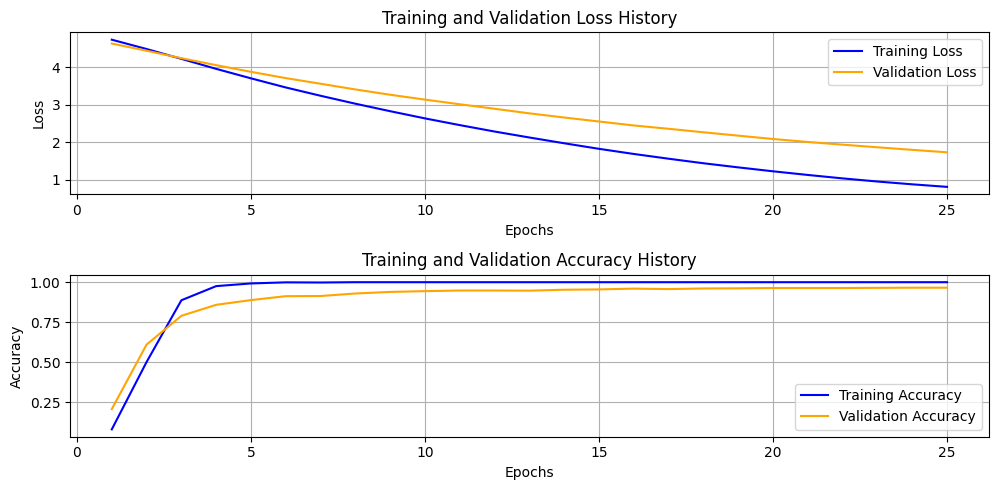

In [76]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [77]:
test_model(model, test_loader)

Test Accuracy: 95.10%
